#  Logistic Regression — Live Class Notebook


**Flow:** Binary Classification Problem → Sigmoid Function → Logistic Regression → Evaluation (Confusion Matrix, Precision, Recall, F1) → Threshold Tuning

---

##  Section 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print('✅ All libraries loaded!')

✅ All libraries loaded!


##  Section 2: The Sigmoid Function

Before we build a model, let's **understand** what logistic regression actually does.  
It takes a linear equation and passes it through the **sigmoid function** to get a probability.

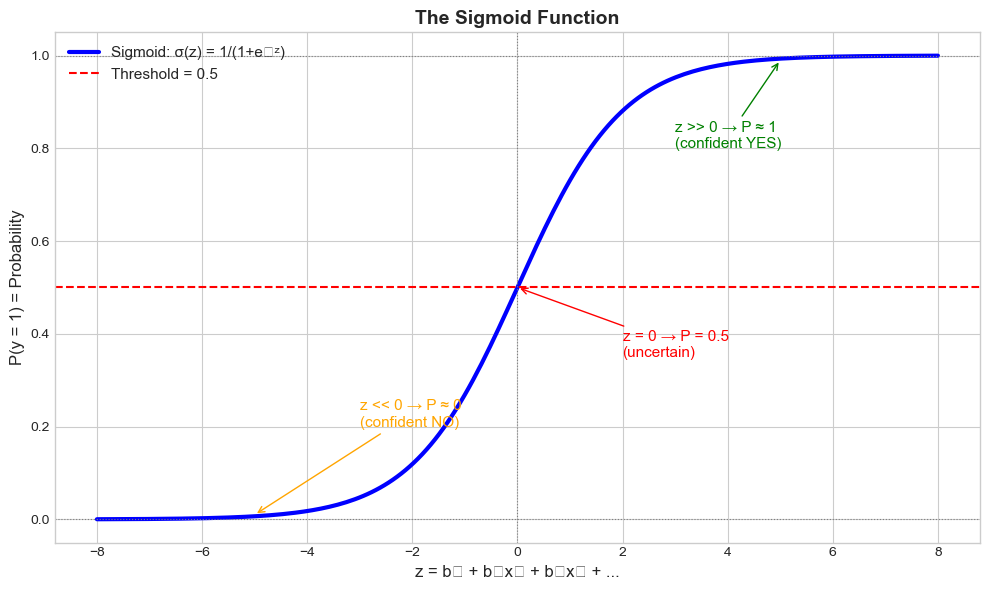

Key points:
  • Output is ALWAYS between 0 and 1 (a probability!)
  • z = 0  →  P = 0.5 (coin flip)
  • z > 0  →  P > 0.5 (lean towards class 1)
  • z < 0  →  P < 0.5 (lean towards class 0)


In [2]:
# Let's visualize the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-8, 8, 200)

plt.figure(figsize=(10, 6))
plt.plot(z, sigmoid(z), 'b-', linewidth=3, label='Sigmoid: σ(z) = 1/(1+e⁻ᶻ)')

# Reference lines
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='Threshold = 0.5')
plt.axhline(y=0, color='gray', linestyle=':', linewidth=0.8)
plt.axhline(y=1, color='gray', linestyle=':', linewidth=0.8)
plt.axvline(x=0, color='gray', linestyle=':', linewidth=0.8)

# Annotations
plt.annotate('z = 0 → P = 0.5\n(uncertain)', xy=(0, 0.5), xytext=(2, 0.35),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=11, color='red')
plt.annotate('z >> 0 → P ≈ 1\n(confident YES)', xy=(5, 0.99), xytext=(3, 0.8),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=11, color='green')
plt.annotate('z << 0 → P ≈ 0\n(confident NO)', xy=(-5, 0.01), xytext=(-3, 0.2),
            arrowprops=dict(arrowstyle='->', color='orange'), fontsize=11, color='orange')

plt.xlabel('z = b₀ + b₁x₁ + b₂x₂ + ...', fontsize=12)
plt.ylabel('P(y = 1) = Probability', fontsize=12)
plt.title('The Sigmoid Function', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

print('Key points:')
print('  • Output is ALWAYS between 0 and 1 (a probability!)')
print('  • z = 0  →  P = 0.5 (coin flip)')
print('  • z > 0  →  P > 0.5 (lean towards class 1)')
print('  • z < 0  →  P < 0.5 (lean towards class 0)')

In [3]:
# Quick exercise: What probability does sigmoid give for these z values?
test_values = [-5, -2, -1, 0, 1, 2, 5]

print('z value  →  Sigmoid(z)  →  Prediction (threshold=0.5)')
print('-' * 55)
for z_val in test_values:
    prob = sigmoid(z_val)
    pred = 'Class 1 ✅' if prob >= 0.5 else 'Class 0 ❌'
    print(f'  z = {z_val:>3}  →  P = {prob:.4f}    →  {pred}')

z value  →  Sigmoid(z)  →  Prediction (threshold=0.5)
-------------------------------------------------------
  z =  -5  →  P = 0.0067    →  Class 0 ❌
  z =  -2  →  P = 0.1192    →  Class 0 ❌
  z =  -1  →  P = 0.2689    →  Class 0 ❌
  z =   0  →  P = 0.5000    →  Class 1 ✅
  z =   1  →  P = 0.7311    →  Class 1 ✅
  z =   2  →  P = 0.8808    →  Class 1 ✅
  z =   5  →  P = 0.9933    →  Class 1 ✅


##  Section 3: Create Dataset — Customer Churn Prediction

**Business Problem:** A telecom company wants to predict which customers will **churn** (cancel their subscription).  
If we can predict who's about to leave, we can offer them a discount to stay!

In [4]:
# Create a realistic churn dataset
np.random.seed(42)
n = 1000

# Features
tenure = np.random.exponential(scale=24, size=n).clip(1, 72)        # Months with company
monthly_charges = np.random.normal(65, 25, n).clip(20, 120)         # Monthly bill
contract_length = np.random.choice([1, 12, 24], size=n, p=[0.5, 0.3, 0.2])  # Month-to-month, 1yr, 2yr
support_calls = np.random.poisson(lam=2, size=n)                     # Number of support calls
total_charges = tenure * monthly_charges + np.random.normal(0, 500, n)

# Generate churn (1 = churned, 0 = stayed)
# Churn is MORE likely if: short tenure, high charges, month-to-month contract, many support calls
churn_prob = sigmoid(
    -0.08 * tenure +
    0.03 * monthly_charges +
    -0.8 * (contract_length / 12) +
    0.3 * support_calls +
    -1.5 +
    np.random.normal(0, 0.5, n)
)
churn = (churn_prob > 0.5).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'tenure_months': tenure.round(1),
    'monthly_charges': monthly_charges.round(2),
    'contract_months': contract_length,
    'support_calls': support_calls,
    'total_charges': total_charges.round(2),
    'churn': churn
})

print(f'Dataset: {df.shape[0]} customers, {df.shape[1]} columns')
print(f'\nChurn distribution:')
print(f'  Stayed (0): {(churn == 0).sum()} ({(churn == 0).mean()*100:.1f}%)')
print(f'  Churned (1): {(churn == 1).sum()} ({(churn == 1).mean()*100:.1f}%)')
print(f'\nFirst 5 rows:')
df.head()

Dataset: 1000 customers, 6 columns

Churn distribution:
  Stayed (0): 716 (71.6%)
  Churned (1): 284 (28.4%)

First 5 rows:


,tenure_months,monthly_charges,contract_months,support_calls,total_charges,churn
0,11.3,69.44,24,3,552.21,0
1,72.0,31.62,1,0,2548.08,0
2,31.6,74.50,1,4,2356.07,0
3,21.9,80.26,1,1,2373.64,0
4,4.1,78.99,12,2,812.93,1


##  Section 4: Quick Exploration — Who Churns?

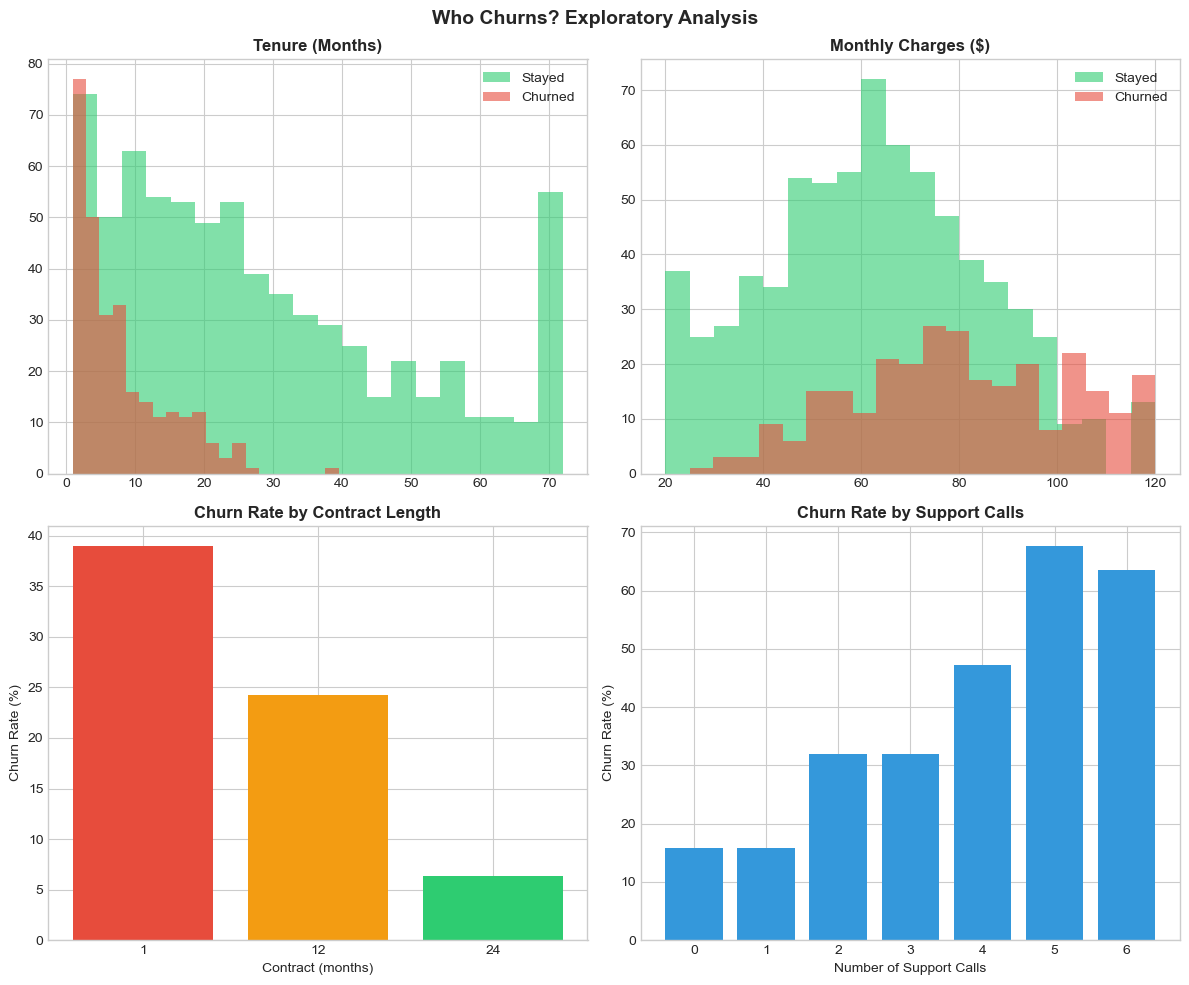

💡 Insights:
  • Short tenure customers churn more
  • Higher monthly charges → more churn
  • Month-to-month contracts have HIGHEST churn
  • More support calls → more churn


In [5]:
# Compare churners vs non-churners
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Tenure
axes[0,0].hist(df[df['churn']==0]['tenure_months'], bins=20, alpha=0.6, color='#2ecc71', label='Stayed')
axes[0,0].hist(df[df['churn']==1]['tenure_months'], bins=20, alpha=0.6, color='#e74c3c', label='Churned')
axes[0,0].set_title('Tenure (Months)', fontweight='bold')
axes[0,0].legend()

# Monthly Charges
axes[0,1].hist(df[df['churn']==0]['monthly_charges'], bins=20, alpha=0.6, color='#2ecc71', label='Stayed')
axes[0,1].hist(df[df['churn']==1]['monthly_charges'], bins=20, alpha=0.6, color='#e74c3c', label='Churned')
axes[0,1].set_title('Monthly Charges ($)', fontweight='bold')
axes[0,1].legend()

# Contract Length
churn_by_contract = df.groupby('contract_months')['churn'].mean() * 100
axes[1,0].bar(churn_by_contract.index.astype(str), churn_by_contract.values, 
              color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1,0].set_title('Churn Rate by Contract Length', fontweight='bold')
axes[1,0].set_ylabel('Churn Rate (%)')
axes[1,0].set_xlabel('Contract (months)')

# Support Calls
churn_by_calls = df.groupby('support_calls')['churn'].mean() * 100
axes[1,1].bar(churn_by_calls.index, churn_by_calls.values, color='#3498db')
axes[1,1].set_title('Churn Rate by Support Calls', fontweight='bold')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_xlabel('Number of Support Calls')

plt.suptitle('Who Churns? Exploratory Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('💡 Insights:')
print('  • Short tenure customers churn more')
print('  • Higher monthly charges → more churn')
print('  • Month-to-month contracts have HIGHEST churn')
print('  • More support calls → more churn')

##  Section 5: Prepare Data — Split & Scale

In [6]:
# Features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training: {X_train.shape[0]} samples')
print(f'Test:     {X_test.shape[0]} samples')
print(f'\nChurn in training: {y_train.mean()*100:.1f}%')
print(f'Churn in test:     {y_test.mean()*100:.1f}%')
print('\n✅ stratify=y ensures same churn ratio in both sets!')

Training: 800 samples
Test:     200 samples

Churn in training: 28.4%
Churn in test:     28.5%

✅ stratify=y ensures same churn ratio in both sets!


In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('✅ Features scaled!')

✅ Features scaled!


## Section 6: Train Logistic Regression

This is where the magic happens! One line to train.

In [8]:
# Train logistic regression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

print('✅ Model trained!')
print(f'\nCoefficients (what the model learned):')
print('-' * 45)
for feature, coef in zip(X.columns, model.coef_[0]):
    direction = '↑ churn' if coef > 0 else '↓ churn'
    print(f'  {feature:<20} : {coef:>7.3f}  ({direction})')
print(f'  {"Intercept":<20} : {model.intercept_[0]:>7.3f}')

print('\n💡 Positive coefficient = increases churn probability')
print('   Negative coefficient = decreases churn probability')

✅ Model trained!

Coefficients (what the model learned):
---------------------------------------------
  tenure_months        :  -3.991  (↓ churn)
  monthly_charges      :   1.874  (↑ churn)
  contract_months      :  -1.634  (↓ churn)
  support_calls        :   1.230  (↑ churn)
  total_charges        :  -0.285  (↓ churn)
  Intercept            :  -3.491

💡 Positive coefficient = increases churn probability
   Negative coefficient = decreases churn probability


## Section 7: Making Predictions

Logistic regression gives us **two things:**
1. `predict_proba()` → the probability (0 to 1)
2. `predict()` → the class label (0 or 1, using threshold 0.5)

In [9]:
# Get probabilities and predictions
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # probability of churn
y_pred = model.predict(X_test_scaled)                # class label (0 or 1)

# Show first 10 customers
results = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted_Prob': y_probs[:10].round(3),
    'Predicted_Class': y_pred[:10]
})
results['Correct?'] = results['Actual'] == results['Predicted_Class']
results['Correct?'] = results['Correct?'].map({True: '✅', False: '❌'})

print('First 10 Test Customers:')
print(results.to_string(index=False))

print('\n💡 Notice: Predicted_Prob is between 0 and 1')
print('   If Prob >= 0.5 → Predicted_Class = 1 (Churn)')
print('   If Prob < 0.5  → Predicted_Class = 0 (Stay)')

First 10 Test Customers:
 Actual  Predicted_Prob  Predicted_Class Correct?
      0           0.000                0        ✅
      0           0.001                0        ✅
      0           0.280                0        ✅
      0           0.030                0        ✅
      0           0.041                0        ✅
      0           0.002                0        ✅
      1           0.450                0        ❌
      0           0.000                0        ✅
      0           0.000                0        ✅
      0           0.028                0        ✅

💡 Notice: Predicted_Prob is between 0 and 1
   If Prob >= 0.5 → Predicted_Class = 1 (Churn)
   If Prob < 0.5  → Predicted_Class = 0 (Stay)


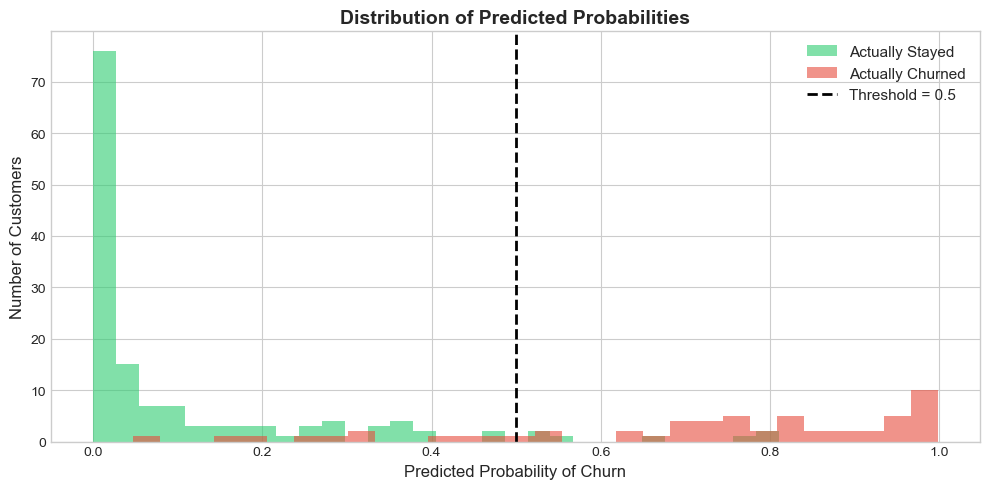

💡 Good model = green bars on LEFT, red bars on RIGHT
   Overlap in the middle = where the model struggles


In [10]:
# Distribution of predicted probabilities
plt.figure(figsize=(10, 5))
plt.hist(y_probs[y_test==0], bins=30, alpha=0.6, color='#2ecc71', label='Actually Stayed')
plt.hist(y_probs[y_test==1], bins=30, alpha=0.6, color='#e74c3c', label='Actually Churned')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Predicted Probability of Churn', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print('💡 Good model = green bars on LEFT, red bars on RIGHT')
print('   Overlap in the middle = where the model struggles')

##  Section 8: Confusion Matrix — The Foundation of All Metrics

This single 2×2 grid tells us EVERYTHING about model performance.

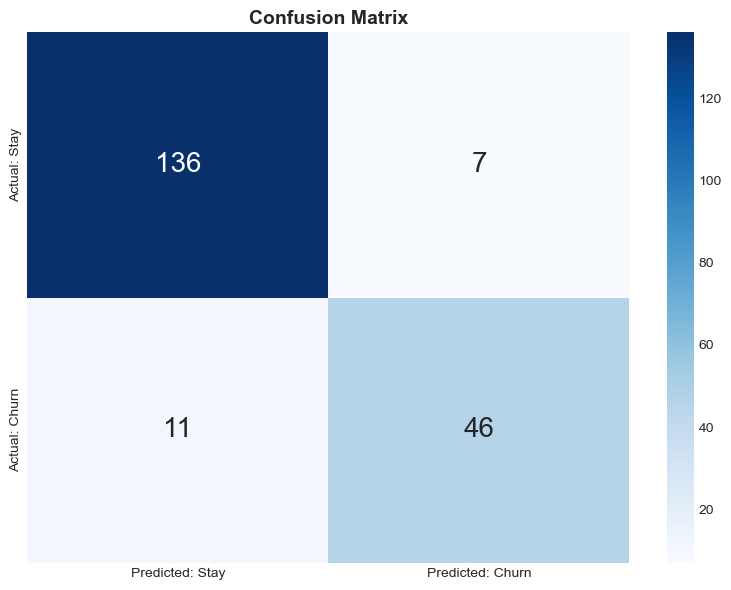

True Negatives  (TN) = 136  → Correctly predicted STAY   ✅
False Positives (FP) =   7  → Wrongly predicted CHURN    ❌ (Type I Error)
False Negatives (FN) =  11  → Missed actual CHURNERS     ❌ (Type II Error)
True Positives  (TP) =  46  → Correctly predicted CHURN  ✅


In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Beautiful visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Stay', 'Predicted: Churn'],
            yticklabels=['Actual: Stay', 'Actual: Churn'],
            annot_kws={'size': 20})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'True Negatives  (TN) = {tn:>3}  → Correctly predicted STAY   ✅')
print(f'False Positives (FP) = {fp:>3}  → Wrongly predicted CHURN    ❌ (Type I Error)')
print(f'False Negatives (FN) = {fn:>3}  → Missed actual CHURNERS     ❌ (Type II Error)')
print(f'True Positives  (TP) = {tp:>3}  → Correctly predicted CHURN  ✅')

##  Section 9: All Evaluation Metrics — Derived from Confusion Matrix

In [12]:
# Calculate all metrics manually (to understand the formulas)
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print('='*55)
print('📏 EVALUATION METRICS (calculated manually)')
print('='*55)

print(f'\n1️⃣  ACCURACY = (TP+TN) / Total = ({tp}+{tn}) / {tp+tn+fp+fn}')
print(f'   = {accuracy:.4f} = {accuracy*100:.1f}%')
print(f'   → Out of all customers, we got {accuracy*100:.1f}% right')

print(f'\n2️⃣  PRECISION = TP / (TP+FP) = {tp} / ({tp}+{fp})')
print(f'   = {precision:.4f} = {precision*100:.1f}%')
print(f'   → When we predict churn, we are right {precision*100:.1f}% of the time')

print(f'\n3️⃣  RECALL = TP / (TP+FN) = {tp} / ({tp}+{fn})')
print(f'   = {recall:.4f} = {recall*100:.1f}%')
print(f'   → Of all actual churners, we caught {recall*100:.1f}%')

print(f'\n4️⃣  F1 SCORE = 2 × (Precision × Recall) / (Precision + Recall)')
print(f'   = 2 × ({precision:.4f} × {recall:.4f}) / ({precision:.4f} + {recall:.4f})')
print(f'   = {f1:.4f} = {f1*100:.1f}%')
print(f'   → Harmonic mean: balances precision and recall')

📏 EVALUATION METRICS (calculated manually)

1️⃣  ACCURACY = (TP+TN) / Total = (46+136) / 200
   = 0.9100 = 91.0%
   → Out of all customers, we got 91.0% right

2️⃣  PRECISION = TP / (TP+FP) = 46 / (46+7)
   = 0.8679 = 86.8%
   → When we predict churn, we are right 86.8% of the time

3️⃣  RECALL = TP / (TP+FN) = 46 / (46+11)
   = 0.8070 = 80.7%
   → Of all actual churners, we caught 80.7%

4️⃣  F1 SCORE = 2 × (Precision × Recall) / (Precision + Recall)
   = 2 × (0.8679 × 0.8070) / (0.8679 + 0.8070)
   = 0.8364 = 83.6%
   → Harmonic mean: balances precision and recall


In [13]:
# Verify with sklearn (should match our manual calculation)
print('\n🔍 Verification with sklearn:')
print(classification_report(y_test, y_pred, target_names=['Stay', 'Churn']))


🔍 Verification with sklearn:
              precision    recall  f1-score   support

        Stay       0.93      0.95      0.94       143
       Churn       0.87      0.81      0.84        57

    accuracy                           0.91       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.91      0.91      0.91       200



### 🤔 Question for students:
For **churn prediction**, which metric is most important — Precision or Recall?

**Answer:** **Recall!** Because:
- FN (missed churner) = We **lose** a customer forever → **expensive!**
- FP (false alarm) = We offer a discount to someone who wasn't leaving → **cheap!**
- So we want to catch ALL churners even if we get some false alarms

##  Section 10: ROC Curve & AUC

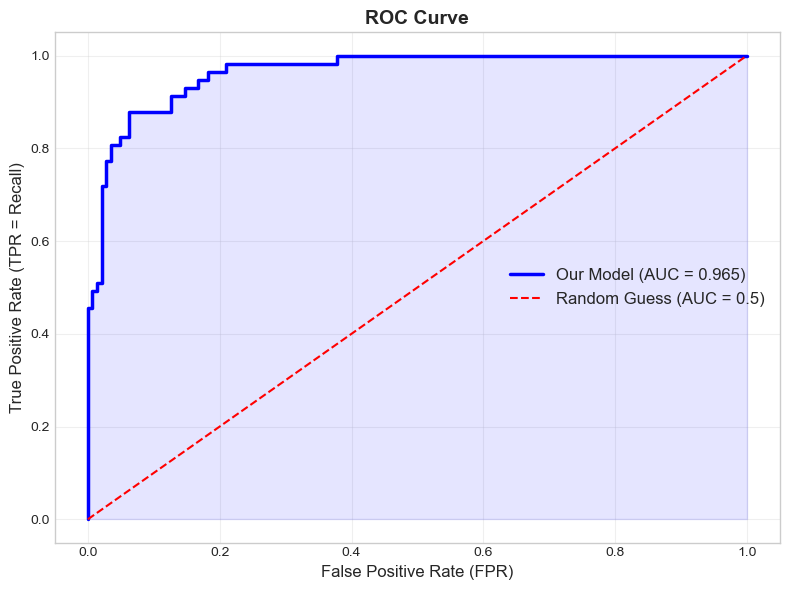

AUC = 0.965

💡 AUC Interpretation:
   1.0  = Perfect model
   0.5  = Random guessing (useless)
   <0.5 = Worse than random (model is inverted!)


In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'Our Model (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1.5, label='Random Guess (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.1, color='blue')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR = Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'AUC = {auc:.3f}')
print(f'\n💡 AUC Interpretation:')
print(f'   1.0  = Perfect model')
print(f'   0.5  = Random guessing (useless)')
print(f'   <0.5 = Worse than random (model is inverted!)')

##  Section 11: Threshold Tuning — The Business Decision

Default threshold is 0.5, but **we can change it!**
- Lower threshold (e.g., 0.3) → catch more churners (higher recall) but more false alarms
- Higher threshold (e.g., 0.7) → fewer false alarms (higher precision) but miss some churners

In [15]:
# Try different thresholds
thresholds_to_try = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f'{"Threshold":>10} {"Accuracy":>10} {"Precision":>10} {"Recall":>10} {"F1":>10}')
print('-' * 55)

for t in thresholds_to_try:
    y_pred_t = (y_probs >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec = recall_score(y_test, y_pred_t)
    f1_t = f1_score(y_test, y_pred_t, zero_division=0)
    print(f'{t:>10.1f} {acc:>10.3f} {prec:>10.3f} {rec:>10.3f} {f1_t:>10.3f}')

print('\n💡 Lower threshold → Higher Recall but Lower Precision')
print('   Higher threshold → Higher Precision but Lower Recall')
print('   Choose based on your BUSINESS NEED!')

 Threshold   Accuracy  Precision     Recall         F1
-------------------------------------------------------
       0.3      0.885      0.743      0.912      0.819
       0.4      0.915      0.833      0.877      0.855
       0.5      0.910      0.868      0.807      0.836
       0.6      0.915      0.917      0.772      0.838
       0.7      0.890      0.927      0.667      0.776

💡 Lower threshold → Higher Recall but Lower Precision
   Higher threshold → Higher Precision but Lower Recall
   Choose based on your BUSINESS NEED!


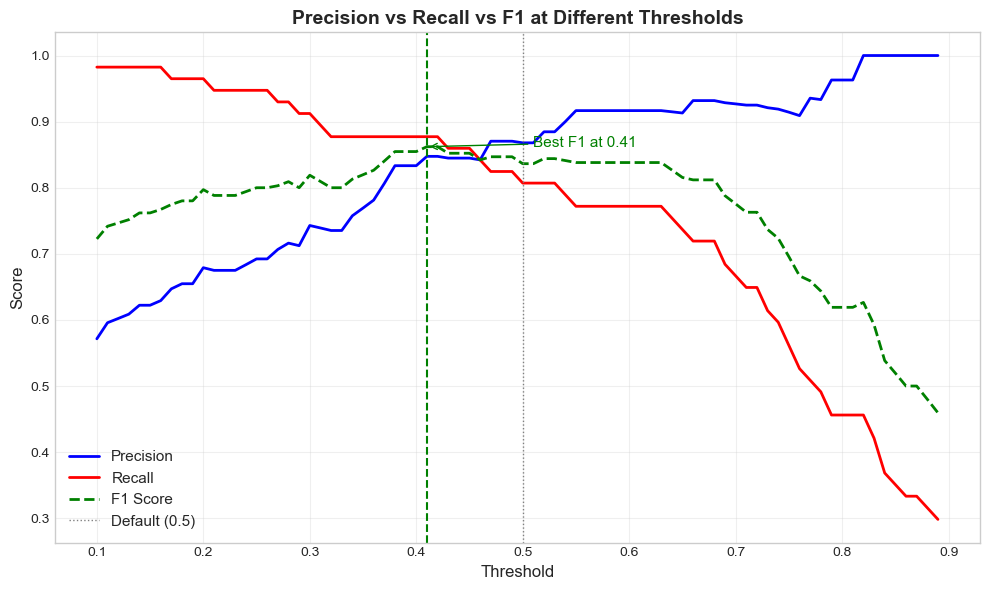

In [16]:
# Visualize the precision-recall tradeoff
thresh_range = np.arange(0.1, 0.9, 0.01)
precisions = []
recalls = []
f1s = []

for t in thresh_range:
    y_p = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_p, zero_division=0))
    recalls.append(recall_score(y_test, y_p, zero_division=0))
    f1s.append(f1_score(y_test, y_p, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresh_range, precisions, 'b-', linewidth=2, label='Precision')
plt.plot(thresh_range, recalls, 'r-', linewidth=2, label='Recall')
plt.plot(thresh_range, f1s, 'g--', linewidth=2, label='F1 Score')
plt.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, label='Default (0.5)')

# Find best F1 threshold
best_idx = np.argmax(f1s)
plt.axvline(x=thresh_range[best_idx], color='green', linestyle='--', linewidth=1.5)
plt.annotate(f'Best F1 at {thresh_range[best_idx]:.2f}', 
            xy=(thresh_range[best_idx], f1s[best_idx]),
            xytext=(thresh_range[best_idx]+0.1, f1s[best_idx]),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=11, color='green')

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision vs Recall vs F1 at Different Thresholds', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 12: Regularization in Logistic Regression

Just like Ridge/Lasso! In sklearn, the parameter is **C = 1/lambda**.  
- Small C → strong regularization  
- Large C → weak regularization

In [17]:
# Compare different C values
c_values = [0.001, 0.01, 0.1, 1, 10, 100]

print(f'{"C value":>10} {"Train Acc":>10} {"Test Acc":>10} {"Gap":>8} {"Non-zero coefs":>15}')
print('-' * 58)

for c in c_values:
    m = LogisticRegression(C=c, penalty='l1', solver='liblinear', random_state=42)
    m.fit(X_train_scaled, y_train)
    tr_acc = m.score(X_train_scaled, y_train)
    te_acc = m.score(X_test_scaled, y_test)
    n_nonzero = np.sum(m.coef_[0] != 0)
    print(f'{c:>10} {tr_acc:>10.4f} {te_acc:>10.4f} {tr_acc-te_acc:>8.4f} {n_nonzero:>10}/5')

print('\n💡 Small C = strong penalty = some features removed (like Lasso!)')
print('   Large C = weak penalty = all features kept')

   C value  Train Acc   Test Acc      Gap  Non-zero coefs
----------------------------------------------------------
     0.001     0.7163     0.7150   0.0013          0/5
      0.01     0.7937     0.7450   0.0487          2/5
       0.1     0.9062     0.9100  -0.0038          4/5
         1     0.9075     0.9200  -0.0125          4/5
        10     0.9087     0.9200  -0.0113          5/5
       100     0.9100     0.9200  -0.0100          5/5

💡 Small C = strong penalty = some features removed (like Lasso!)
   Large C = weak penalty = all features kept


---
## Section 13: Summary

| Step | What We Did |
|---|---|
| Sigmoid | Converts any number → probability (0 to 1) |
| Logistic Regression | z = linear combo → sigmoid(z) = probability → threshold → class |
| Confusion Matrix | TP, TN, FP, FN → foundation of all metrics |
| Accuracy | Overall correctness (can be misleading with imbalanced data!) |
| Precision | "When I predict churn, am I right?" |
| Recall | "Did I catch all the churners?" |
| F1 Score | Balance of precision and recall |
| ROC-AUC | Overall model quality across all thresholds |
| Threshold | Business decision: trade precision ↔ recall |
| Regularization (C) | Small C = strong penalty, prevents overfitting |

---
